Import the library for modelling

In [ ]:
# Import necessary libraries
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import InceptionV3
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from keras.models import Model
from keras.optimizers import Adam
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
import cv2 as cv
import os
from matplotlib import pyplot as plt

Mounted at /content/drive


In [ ]:
!ls "/content/drive/Shareddrives/Capstone_Project/Capstone_datasets/train"

 _annotations.csv  'Bika Ambon'    'Kue Cubit'	  'Pepes Ikan'	 Rendang  'Telur Balado'   Tiramisu
 Bakso		   'Dadar Gulung'  'Nasi Goreng'  'Putu Ayu'	 Sate	  'Tempe Bacem'


In [ ]:
import re

train_dir = '/content/drive/Shareddrives/Capstone_Project/Capstone_datasets/train'
valid_dir = '/content/drive/Shareddrives/Capstone_Project/Capstone_datasets/valid'
test_dir = '/content/drive/Shareddrives/Capstone_Project/Capstone_datasets/test'

Showing the distributions of the label in datasets

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

img_height, img_width = 32, 32
batch_size = 20

# Load datasets
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size,
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    valid_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size,
)
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size,
)

# Model
model = tf.keras.Sequential([
    layers.Rescaling(1./255),
    layers.Conv2D(32, 3, activation="relu"),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation="relu"),  # Adjusted to 64 filters
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation="relu"),  # Adjusted to 128 filters
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(256, activation="relu"),  # Adjusted to 256 units
    layers.Dropout(0.5),  # Added dropout for regularization
    layers.Dense(23, activation="softmax"),
])

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy') > 0.80):
      print("\nAkurasi telah mencapai 80%, hentikan proses training!")
      self.model.stop_training = True

callbacks = myCallback()

# Compile the model
model.compile(
    optimizer="adam",
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50
)

# Optionally, evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_ds)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

Found 9588 files belonging to 12 classes.
Found 1432 files belonging to 12 classes.
Found 478 files belonging to 12 classes.
Epoch 1/50
480/480 [==============================] - 1900s 4s/step - loss: 1.9383 - accuracy: 0.3471 - val_loss: 1.6458 - val_accuracy: 0.4134
Epoch 2/50
480/480 [==============================] - 65s 135ms/step - loss: 1.4980 - accuracy: 0.4729 - val_loss: 1.5272 - val_accuracy: 0.4763
Epoch 3/50
480/480 [==============================] - 65s 134ms/step - loss: 1.3565 - accuracy: 0.5229 - val_loss: 1.6107 - val_accuracy: 0.4797
Epoch 4/50
480/480 [==============================] - 65s 135ms/step - loss: 1.2428 - accuracy: 0.5677 - val_loss: 1.4907 - val_accuracy: 0.5594
Epoch 5/50
480/480 [==============================] - 68s 141ms/step - loss: 1.1264 - accuracy: 0.6192 - val_loss: 1.3543 - val_accuracy: 0.5936
Epoch 6/50
480/480 [==============================] - 63s 129ms/step - loss: 1.0014 - accuracy: 0.6575 - val_loss: 1.2270 - val_accuracy: 0.6306
Epoch 

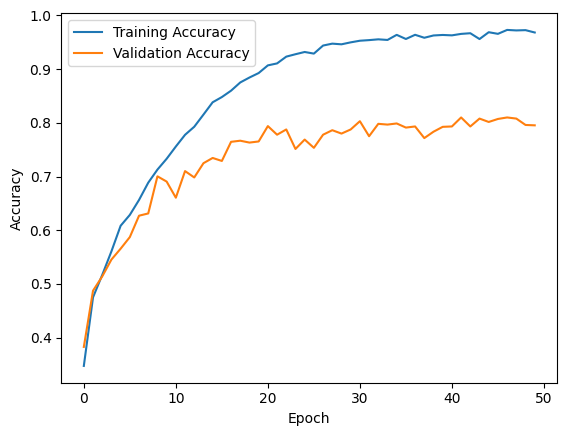

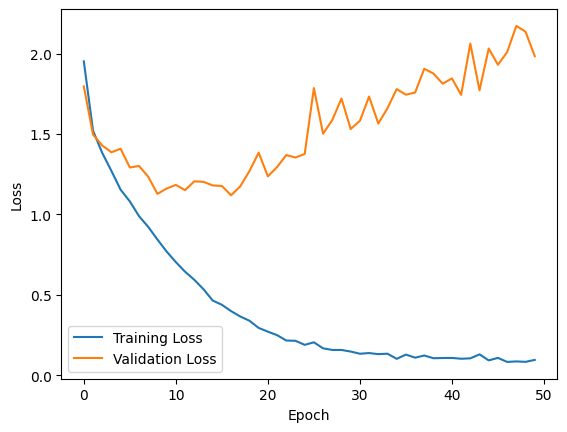

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open("model.tflite", 'wb') as f:
  f.write(tflite_model)